In [1]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from AsymptoticRingModeSolver import MakeDataSet, GetFitParameters, GetFittedFunctionValue

# Generate Waveguide Mode Property Dataset
The code below illustrates how to create a data set of mode properties (utilizing the open source Femwell mode solver), which will then be used to solve for the necessary fit parameters needed in the asymptotic mode solver. We start by defining the waveguide properties used in the mode solver. Here the Sellmeier coefficients correspond to a core of silicon nitride with a silicon oxide cladding.

In [2]:
simPars = {
    "wavelength" : np.array([1.5, 1.55, 1.6], dtype=float),                              # Wavelength in (um)
    "wg_width" : np.array([2.3, 2.4, 2.5], dtype=float),                                 # Waveguide width in (um)
    "wg_thickness" : np.array([0.38], dtype=float),                                      # Waveguide thickness in (um)
    "bendCurvature" : np.linspace(0, 0.05, 10, dtype=float),                             # Waveguide bend curvature (um^-1)
    "sellmeierCoeffs_core" : {"A" : [3.0249, 40314], "B" : [0.1353406, 1239.842]},                                 # Sellmeier coefficients for the core material (A unitless, B in um)
    "sellmeierCoeffs_clad" : {"A" : [0.6961663, 0.4079426, 0.8974794], "B" : [0.0684043, 0.1162414, 9.896161]}     # Sellmeier coefficients for the cladding material (A unitless, B in um)
}

Next we solve for the mode properties (effective refractive index, radiation loss (dB/cm), self- and cross-coupling overlap strength) of the TE00 and TE01 mode for each combination of parameters listed in the above dictionary (in this case 2x3x3x1x10 = 180 modes). The result is saved as a csv file for use later in the parameter fitting.

(Note: Solving for the self- and cross-coupling overlap strengths involves fitting a variety of overlap values, and consequentally requires at least a few, in this case 10, bend curvature values)

In [3]:
df = MakeDataSet(simPars)
df.to_csv("generatedData/sampleModeDataSet.csv")

Modes: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [03:40<00:00,  1.22s/it]


Due to the large number of modes and mode overlaps computed, for large dataset generation it is highly recommended to run smaller instances in parallel and merge the resulting data frames.

After solving for the mode properties, we can use the generated csv files to perform a fit over the generation parameter space (wavelength, curvature, and waveguide width). This will allow the methods which generate the asymptotic fields to easily interpolate the mode properties. For this example, we will use a pregenerated dataset containing the computed mode properties for 13,600 modes corresponding to a selection of wavelengths from 1.45 um to 1.65 um, waveguide widths from 2.1 um to 2.9 um, and bend curvatures from 0 um^-1 to 0.05 um^-1 (waveguide thickness has been fixed at 0.38 um).

In [4]:
dataFileVec = ["sampleData/pregeneratedSampleData.csv"]
fittedPars = GetFitParameters(dataFileVec)

Then save the fitting parameters to a binary file which can be used in when solving for the asymptotic fields.

In [5]:
parameterFile = open("generatedData/sampleFittedPars", "wb")
pickle.dump(fittedPars, parameterFile)
parameterFile.close()

We can also print a selection of 2D slices of the fitted functions overtop of the fitting data to visualize the quality of the fitting.

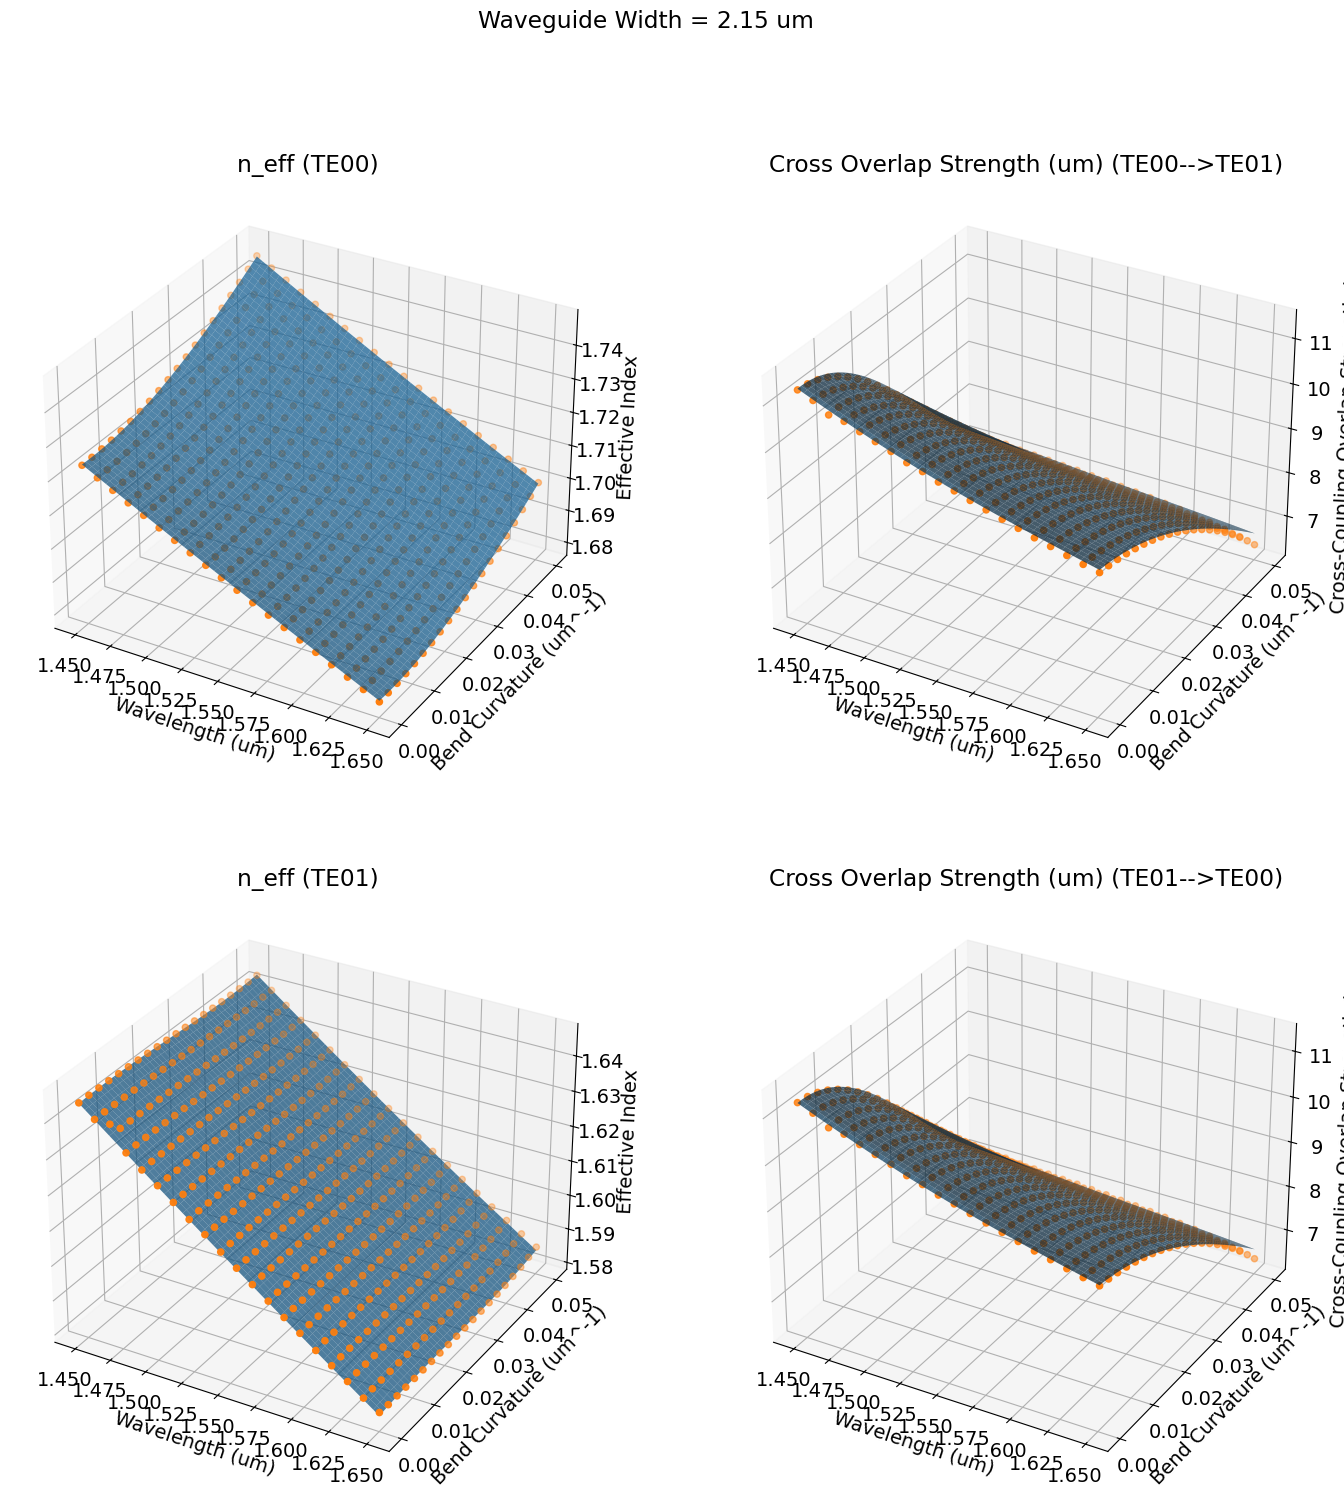


 -------------------------------------------------------------------------------------------------------------------------------------



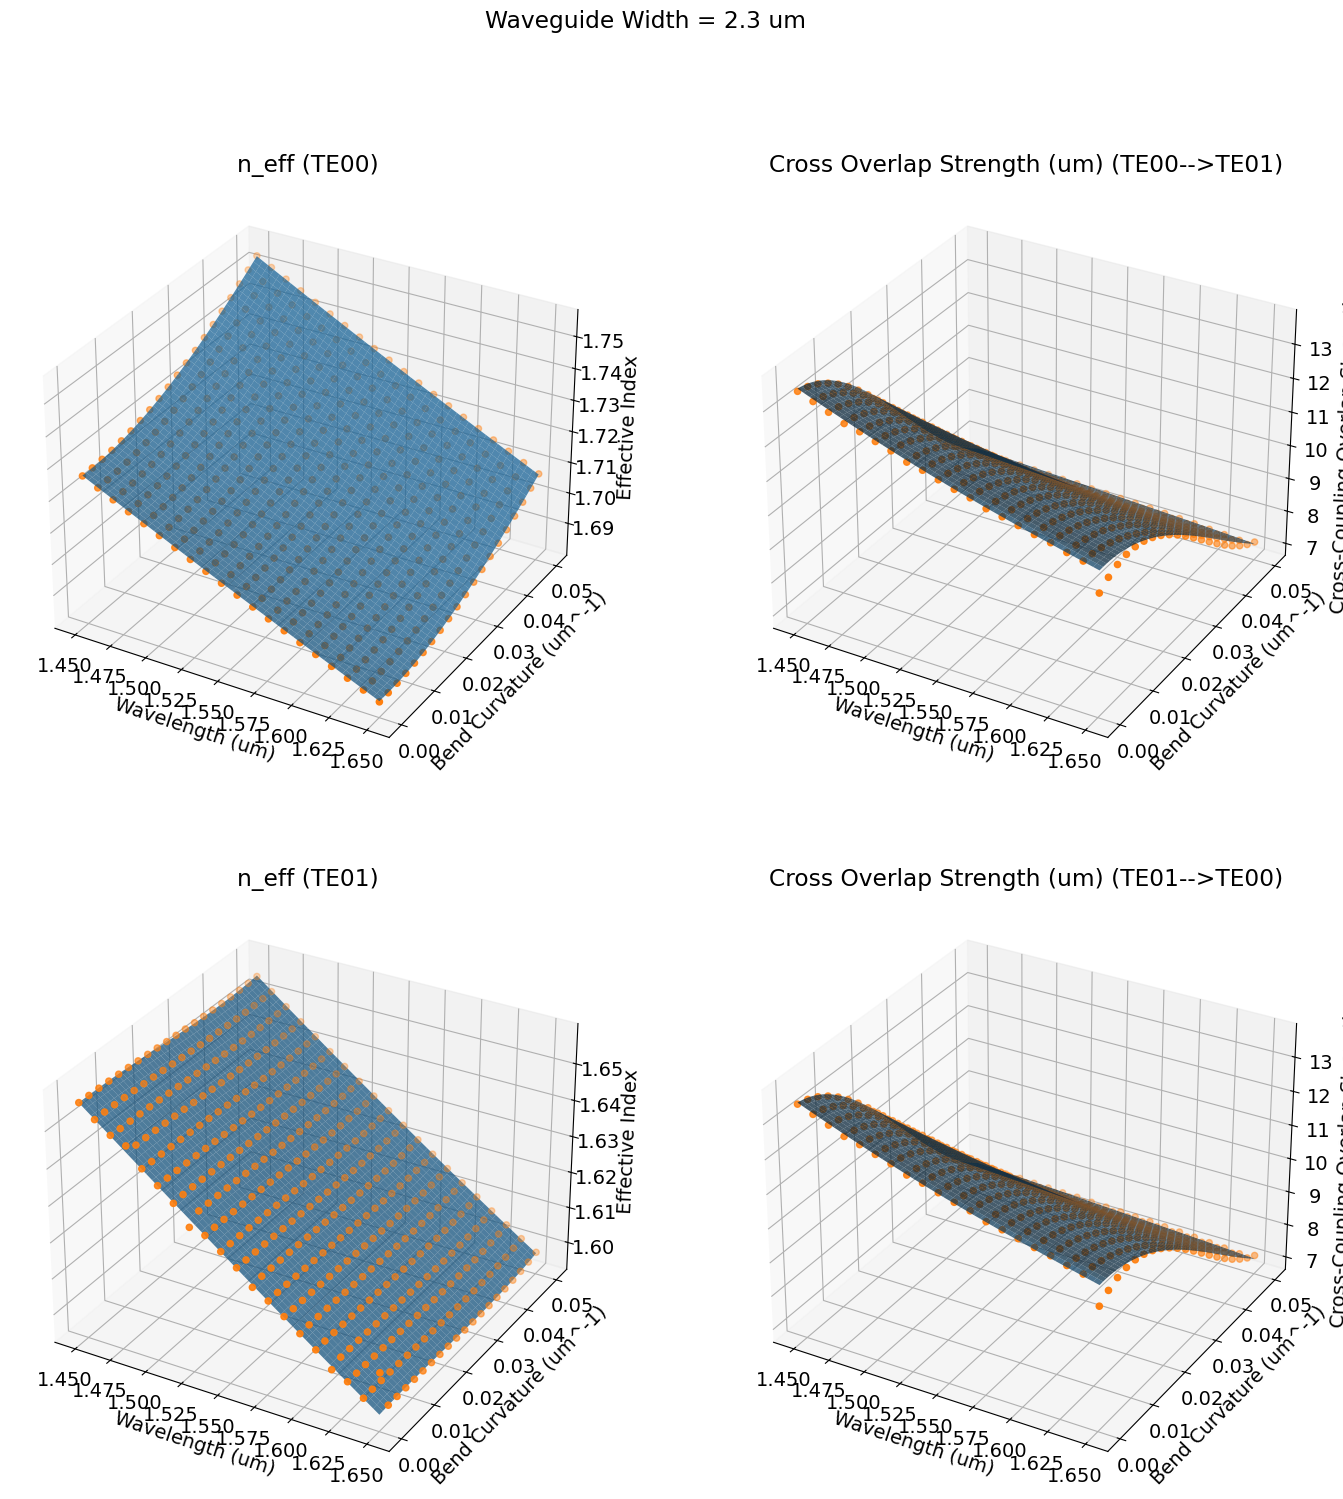


 -------------------------------------------------------------------------------------------------------------------------------------



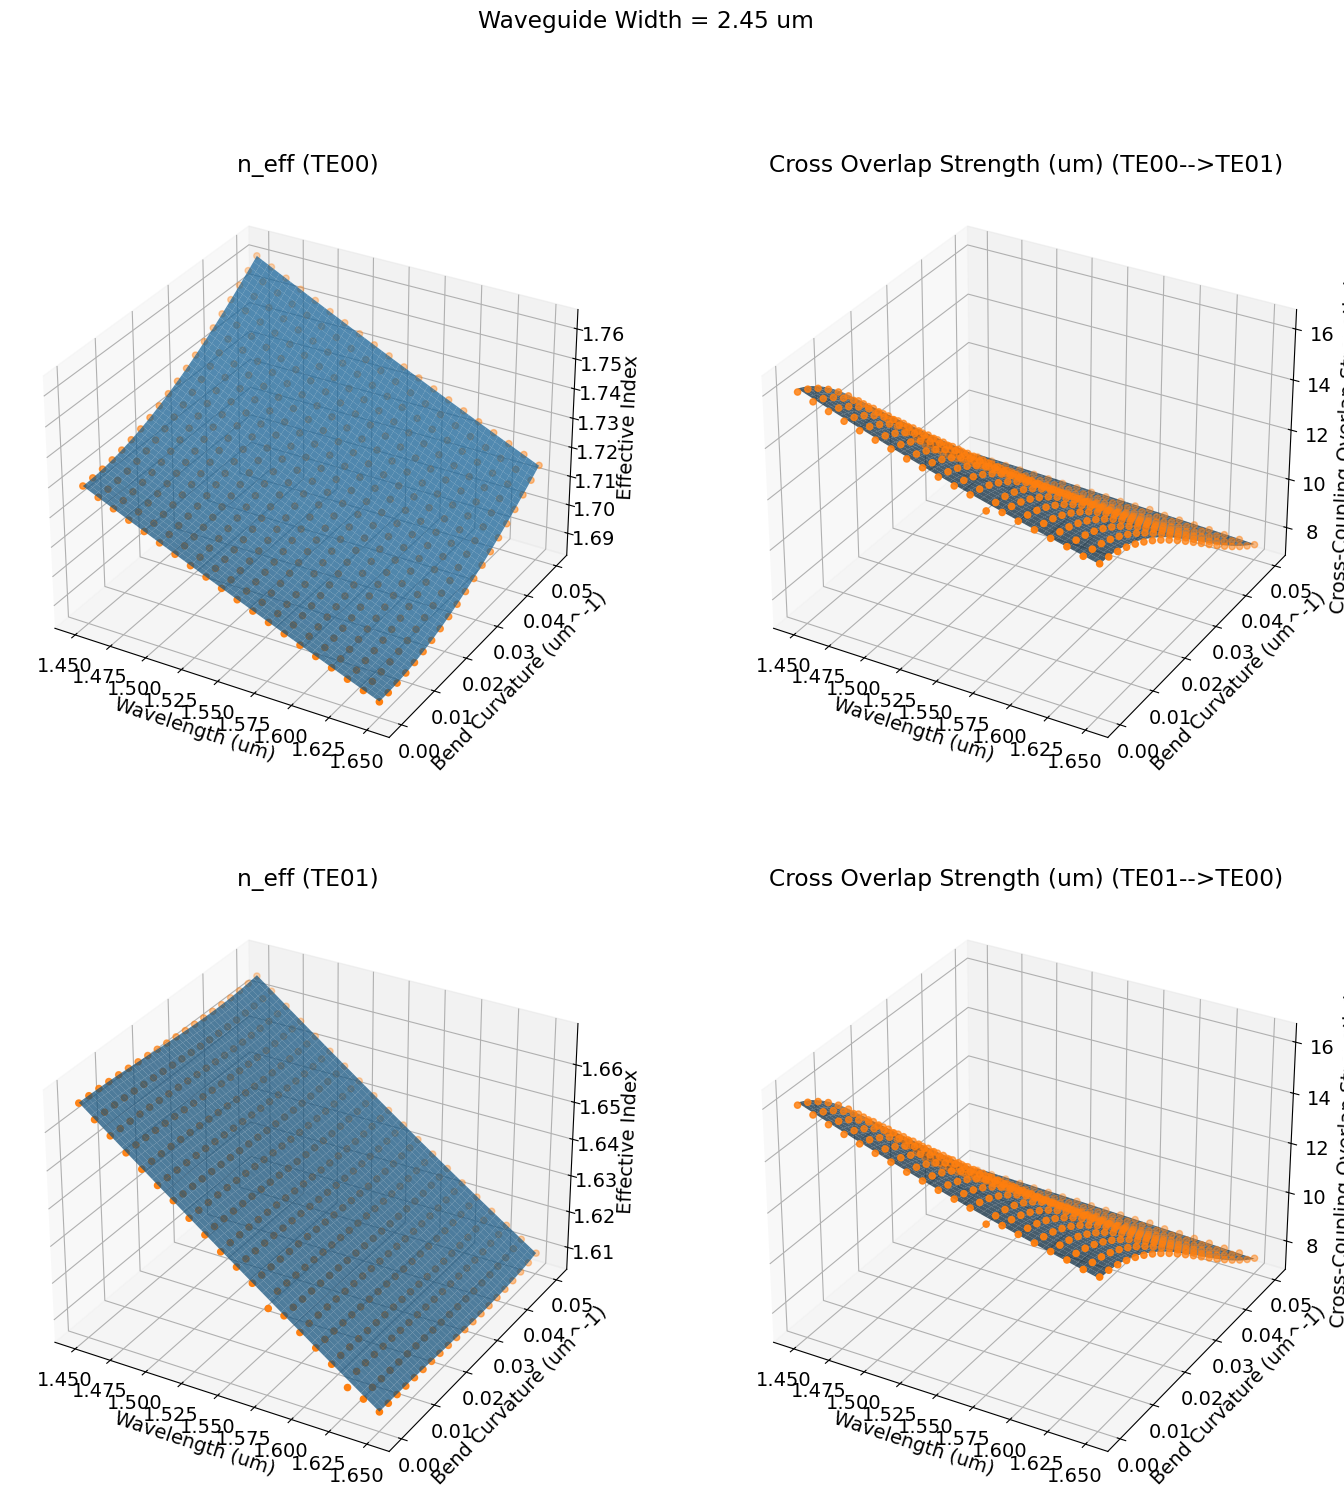


 -------------------------------------------------------------------------------------------------------------------------------------



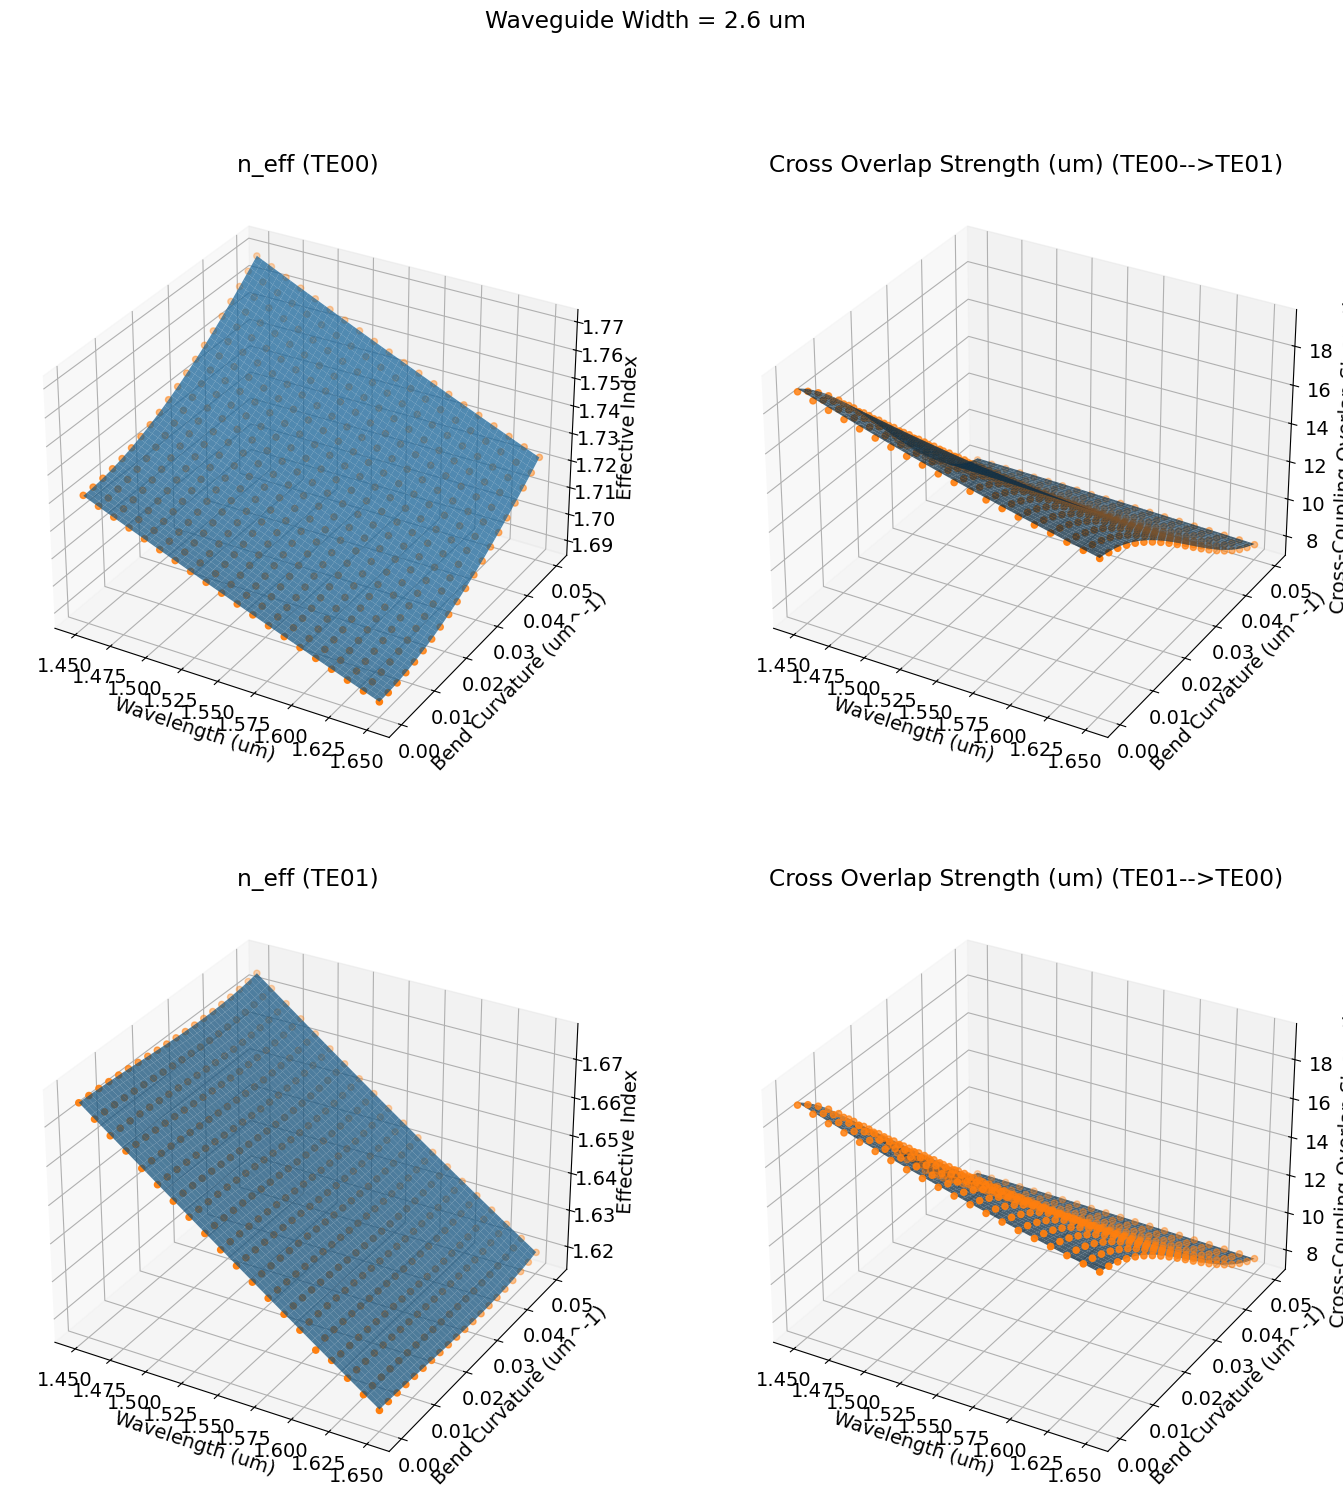


 -------------------------------------------------------------------------------------------------------------------------------------



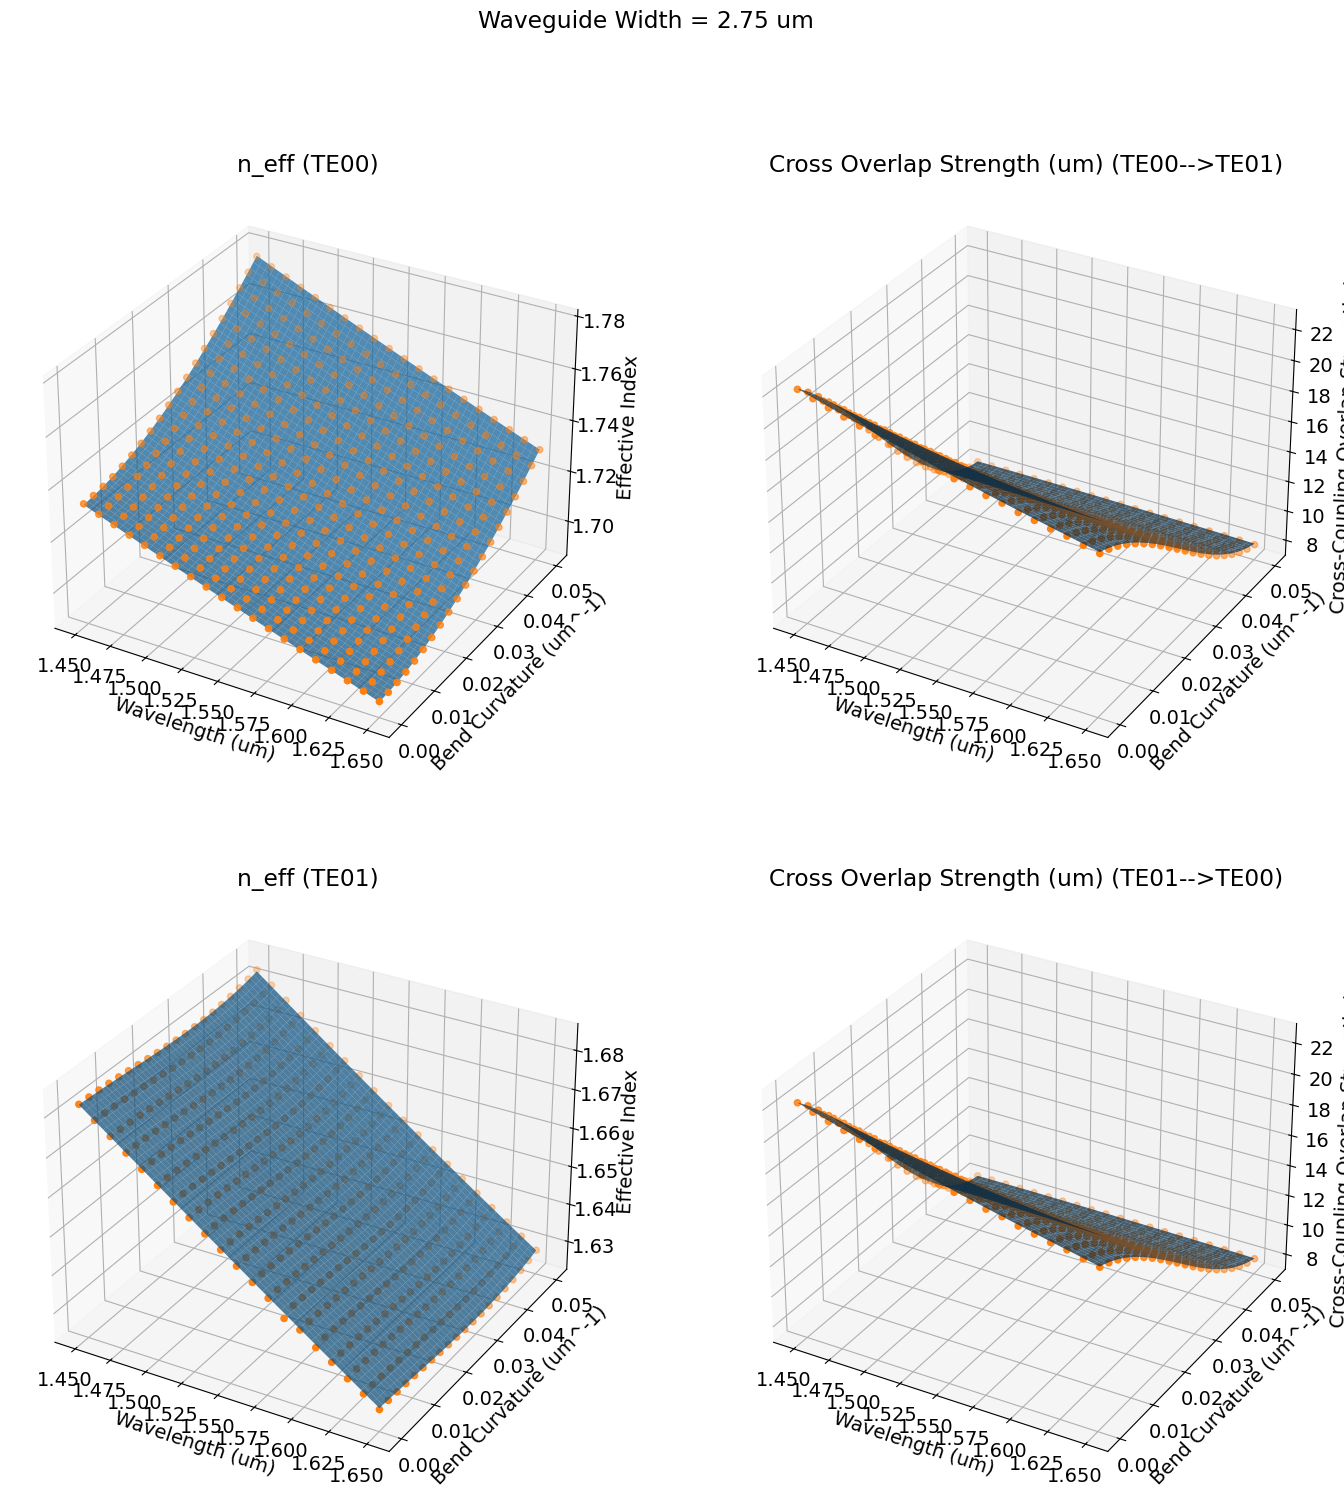


 -------------------------------------------------------------------------------------------------------------------------------------



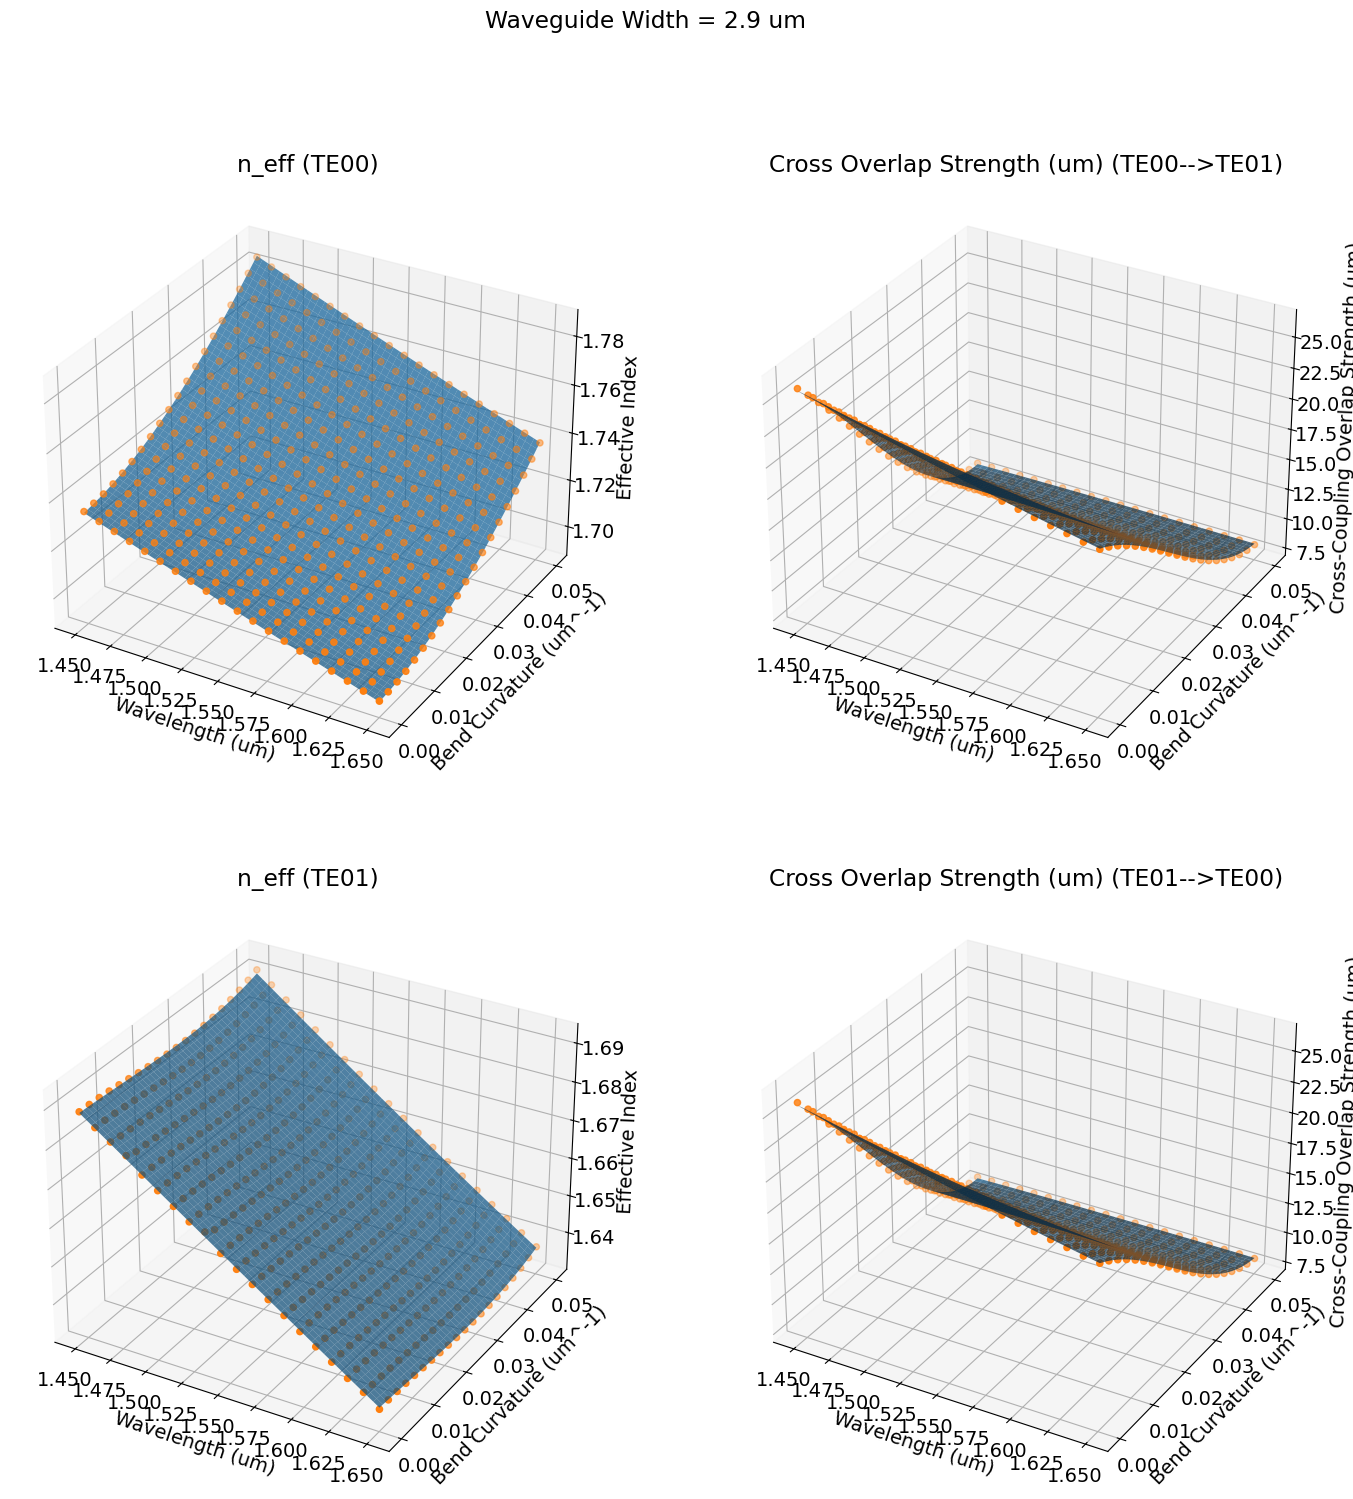


 -------------------------------------------------------------------------------------------------------------------------------------



In [6]:
df = pd.read_csv("sampleData/pregeneratedSampleData.csv")
waveguideWidths = list(set(df[:]["wg_width"]))
waveguideWidths.sort()

plt.rc("font", size=14)
for width in waveguideWidths[1::3]:
    fig, ax = plt.subplots(2, 2, subplot_kw={"projection": "3d"})
    fig.set_size_inches(17, 17)
    fig.suptitle(f"Waveguide Width = {width} um")
    
    for modeNum in [1, 2]:
        # Parse the data for the given waveguide width and mode number
        df_parsed = df.loc[(df["wg_width"] == width) & (df["mode_number"] == modeNum)]
    
        # Extract the data
        wavelengths = df_parsed["wavelength"].tolist()
        bendCurvature = df_parsed["bend_curvature"].tolist()
        n_eff = np.array(df_parsed["n_eff"].tolist(), dtype=float)
        crossOverlapStrength = np.array(df_parsed["crossOverlapStrength"].tolist(), dtype=complex)

        # Get the fitted values
        wavelength_axis = np.linspace(min(wavelengths), max(wavelengths))
        curvature_axis = np.linspace(min(bendCurvature), max(bendCurvature))
        X, Y = np.meshgrid(wavelength_axis, curvature_axis)

        n_eff_fitted = GetFittedFunctionValue(fittedPars[f"neffPars_mode{modeNum}_raw"], X, Y, width)
        crossOverlapStrength_fitted = GetFittedFunctionValue(fittedPars[f"crossHOMcoupling_mode{modeNum}_raw"], X, Y, width)

        # Add the plots
        ax[modeNum - 1, 0].plot_surface(X, Y, np.absolute(n_eff_fitted), alpha=0.75)
        ax[modeNum - 1, 0].scatter(wavelengths, bendCurvature, n_eff, c="tab:orange")
        ax[modeNum - 1, 0].set_xlabel("Wavelength (um)")
        ax[modeNum - 1, 0].set_ylabel("Bend Curvature (um^-1)")
        ax[modeNum - 1, 0].set_zlabel("Effective Index")
        ax[modeNum - 1, 0].set_title(f"n_eff ({'TE00' if (modeNum == 1) else 'TE01'})")

        ax[modeNum - 1, 1].plot_surface(X, Y, np.absolute(crossOverlapStrength_fitted), alpha=0.75)
        ax[modeNum - 1, 1].scatter(wavelengths, bendCurvature, np.absolute(crossOverlapStrength), c="tab:orange")
        ax[modeNum - 1, 1].set_xlabel("Wavelength (um)")
        ax[modeNum - 1, 1].set_ylabel("Bend Curvature (um^-1)")
        ax[modeNum - 1, 1].set_zlabel("Cross-Coupling Overlap Strength (um)")
        ax[modeNum - 1, 1].set_title(f"Cross Overlap Strength (um) ({'TE00-->TE01' if (modeNum == 1) else 'TE01-->TE00'})")

    plt.show()
    print("\n -------------------------------------------------------------------------------------------------------------------------------------\n")
    